In [57]:
import pandas as pd
import os
from scipy.interpolate import PchipInterpolator
import numpy as np
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt

In [58]:
def interpolador(subject, method, size):
    # data = np.array([int(line.strip()) for line in subject.to_numpy()])  # Si lo obtienes de un DataFrame
    data = subject
    x = np.arange(len(data))
    
    # Crear 'size' puntos equidistantes
    x_new = np.linspace(0, len(data) - 1, size*(len(data)-1) + len(data))
    
    if method == 'lineal':
        data_interp = np.interp(x_new, x, data)
    elif method == 'herm':
        interpolator = PchipInterpolator(x, data)
        data_interp = interpolator(x_new)
    
    return x_new, data_interp

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def arm_detector(data, num_ventanas=30, b=0.4):
    n = len(data)
    x = np.arange(n)
    
    # Calcular el tamaño de cada ventana
    window_size = n // num_ventanas

    # Lista para almacenar los porcentajes de puntos dentro de las regiones
    porcentajes = []

    # Ajustar y graficar el ajuste lineal por cada ventana con las líneas paralelas
    for i in range(0, n, window_size):
        end = i + window_size
        if end > n:
            end = n
        
        x_window = x[i:end].reshape(-1, 1)
        y_window = data[i:end]
        
        # Crear y ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(x_window, y_window)
        
        # Obtener la pendiente y la intersección de la recta ajustada
        pendiente = modelo.coef_[0]
        interseccion = modelo.intercept_
        
        # Predecir valores ajustados
        y_pred = modelo.predict(x_window)
                
        # Calcular las rectas paralelas desplazadas por 'b'
        y_paralela_superior = pendiente * x_window + (interseccion + b)
        y_paralela_inferior = pendiente * x_window + (interseccion - b)
                
        # Calcular el porcentaje de datos dentro de la región delimitada por las líneas paralelas
        dentro_region = np.sum((y_window >= y_paralela_inferior.flatten()) & (y_window <= y_paralela_superior.flatten()))
        fuera_region = len(y_window) - dentro_region
        
        # Calcular el porcentaje de datos dentro de la región respecto a los datos fuera de la región
        porcentaje = (dentro_region * 100)/(dentro_region + fuera_region)
        porcentajes.append(porcentaje)

    def indice_mayor_90(arr):
        n = len(arr)
    
        # Revisar cada índice para encontrar el primero que cumpla la condición
        for i in range(n):
            if np.all(arr[i:] > 90):
                return i
        # Si no hay tal índice, regresar el último índice
        return n - 1
    
    indice = indice_mayor_90(np.array(porcentajes))*window_size
    return indice

def J_univariante(X,tau, corte, i):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    # ff1 = np.angle(np.fft.rfft(x1))
    # ff2 = np.angle(np.fft.rfft(y1))
    ff1 = np.random.uniform(-np.pi, np.pi, i)
    ff2 = np.random.uniform(-np.pi, np.pi, i)
    if corte:
        print(len(ff1),len(ff2))
        transition_point1 = arm_detector(ff1)
        transition_point2 = arm_detector(ff2)
        if transition_point1 != transition_point2:
            transition_point1 = transition_point2 = min(transition_point1, transition_point2)
        ff2 = ff2[:transition_point2]
        ff1 = ff1[:transition_point1]
        print(len(ff1),len(ff2))
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

In [4]:
def graficar_angulos_en_circulo(angulos):
    # Crear una figura y un set de ejes
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    
    # Dibujar el círculo unitario
    circulo = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
    ax.add_artist(circulo)

    # Coordenadas del círculo unitario
    x_circulo = np.cos(np.linspace(0, 2 * np.pi, 100))
    y_circulo = np.sin(np.linspace(0, 2 * np.pi, 100))
    ax.plot(x_circulo, y_circulo, 'b--')  # Línea del círculo

    # Graficar los puntos correspondientes a los ángulos en el círculo unitario
    for angulo in angulos:
        x = np.cos(angulo)
        y = np.sin(angulo)
        ax.plot([0, x], [0, y], color='gray', linestyle='--')  # Línea desde el origen
        ax.plot(x, y, 'ro')  # Punto en el círculo

    # Ajustes del gráfico
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_title('Ángulos en el círculo unitario')
    
    # Dibujar los ejes
    ax.axhline(0, color='black',linewidth=0.5)
    ax.axvline(0, color='black',linewidth=0.5)

    # Mantener proporciones iguales
    ax.set_aspect('equal')
    plt.grid(True)
    plt.show()


5110 5110
1700 1700
0.6947710644691452


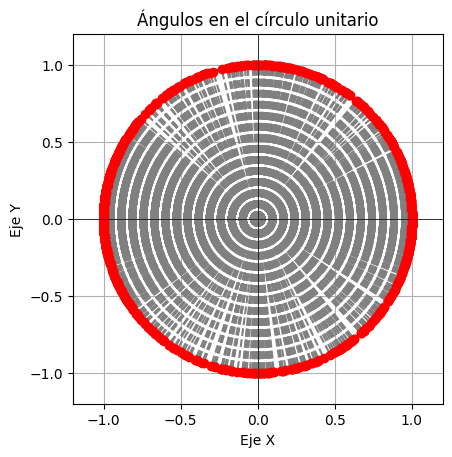

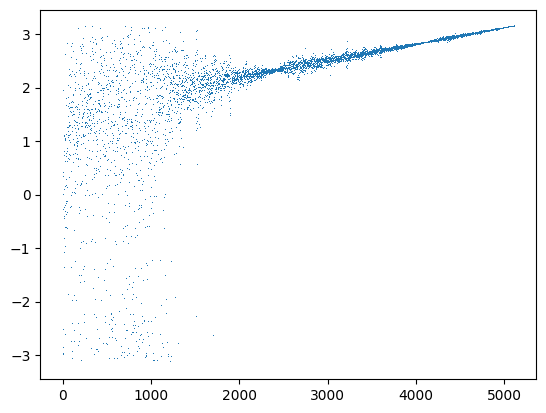

In [162]:
# ara = [np.sin(x) for x in np.linspace(-25, 25, 15000)]
# ara = np.array([2]*2000)
# ara = np.loadtxt("lorenz_x_28.0.txt")
ara = interpolador(composers_Hz['Alkan']['Serie_114'], 'herm', 5)[1]
corte = len(ara)
j, a = J_univariante(ara, 1, True)
print(j)
graficar_angulos_en_circulo(a)

plt.plot(np.angle(np.fft.rfft(ara)),",")
# plt.xlim(0,corte)
plt.show()

In [60]:
#dataframe datos de compositores 

datos_composers = {}
carpeta = r'Sequences\labels'
archivos_en_carpeta = os.listdir(carpeta)
print(archivos_en_carpeta)
index0 = 0
indice = 0

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa, header = None)
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    datos_composers[composer] = {} #genero bibio para composer
    datos_composers[composer]['Birth_year'] = archivo.split('-')[0] #año de nacimiento
    index1 = serie.iloc[0, 0].split('\t')[0] #el # del primer serie del composer
    index2 = int(serie.iloc[len(serie)-3, 0].split('\t')[0]) - index0 # # Piezas
    index0 = index2 + index0 # numero total de piezas anteriores
    datos_composers[composer]['# Piezas'] = index2 # Piezas
    datos_composers[composer]['Indice'] = indice
    indice += 1

datos_composers_df = pd.DataFrame(datos_composers)
print('Total Pieces = ',datos_composers_df.sum(axis=1)[1])
print(datos_composers_df)    

['1397-dufay-Labels.txt', '1500-morales-Labels.txt', '1521-desprez-Labels.txt', '1525-palestrina-Labels.txt', '1532-lasso-Labels.txt', '1538-byrd-Labels.txt', '1548-victoria-Labels.txt', '1557-gabrielis-Labels.txt', '1563-dowland-Labels.txt', '1566-gesualdo-Labels.txt', '1567-monteverdi-Labels.txt', '1583-frescobaldi-Labels.txt', '1587-scheidt-Labels.txt', '1616-froberger-Labels.txt', '1629-anglebert-Labels.txt', '1632-lully-Labels.txt', '1637-buxtehude-Labels.txt', '1653-pachelbel-Labels.txt', '1668-couperin-Labels.txt', '1671-albinoni-Labels.txt', '1678-vivaldi-Labels.txt', '1681-telemann-Labels.txt', '1682-dandrieu-Labels.txt', '1683-rameau-Labels.txt', '1685-handel-Labels.txt', '1685-scarlatti-Labels.txt', '1688-zipoli-Labels.txt', '1721-bach-js-Labels.txt', '1732-haydn-Labels.txt', '1736-albrechtsberger-Labels.txt', '1752-clementi-Labels.txt', '1756-mozart-Labels.txt', '1770-beethoven-Labels.txt', '1771-cramer-Labels.txt', '1782-paganini-Labels.txt', '1797-schubert-Labels.txt', '1

C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_6052\1761750877.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Total Pieces = ',datos_composers_df.sum(axis=1)[1])


In [2]:
# interp = composers['Morales']['Serie_25']
# # interp = interpolador(subject,'herm', 10000)
# def m(composer, serie):
#     return interpolador(composers_Hz[composer]['Serie_'+str(serie)], 'herm', 5)[1]
# for interp in [m('Debussy', 166),m('Debussy', 18),m('Debussy', 16),m('Faure',43),m('Dvorak',50),m('Dvorak', 49),m('Dvorak',48),m('Tchaikovsky', 126),m('Tchaikovsky', 120),m('Alkan', 120),m('Alkan', 114),m('Alkan', 42),m('Liszt', 22),m('Chopin',152),m('Chopin', 125), m('Schubert',7)]:
#     ff1 = np.angle(np.fft.rfft(interp[1:]))
#     ff2 = np.angle(np.fft.rfft(interp[:-1]))
#     transition_point1 = arm_detector(ff1)
#     transition_point2 = arm_detector(ff2)
    
#     if transition_point1 != transition_point2:
#         transition_point1 = transition_point2 = min(transition_point1, transition_point2)

#     fig, ax = plt.subplots(1, 2, figsize=(10, 4))
#     # plt.title(interp)
#     ax[0].plot(ff1, '.')
#     ax[0].axvline(x=transition_point1, color='red', linestyle='--', alpha=0.5)
    
#     ax[1].plot(ff2, '.')
#     ax[1].axvline(x=transition_point2, color='red', linestyle='--', alpha=0.5)
#     plt.tight_layout()
#     plt.show()

#     # J = J_univariante(interp, 1, True)
#     # print(J)

In [61]:
composers = {}
M = 0
carpeta = r'Sequences\Series'
archivos_en_carpeta = os.listdir(carpeta)

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa)
    # escoge una serie
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    composers[composer] = {}

    for pieza in range( datos_composers[composer]['# Piezas'] ):
        N = serie.iloc[0, 0].split('\t')[1] # # de elementos por pieza
        M = int(N) + M
        index_n1 = 0 
        index_n2 = int(N)+2 
        serie_n = serie[index_n1 + 2:index_n2].reset_index(drop=True) # resetear index
        serie = serie[index_n2 +1:] # recortar serie Original
        serie_n.index += 1 # que index empiece desde 1
        num_serie_T = serie.columns[0]  # numero de serie de todo el dataset
        num_serie = pieza + 1
        composers[composer]['Serie_'+str(num_serie)] = serie_n.squeeze().to_numpy().astype(float) # agregamos pieza al dicc composer con key como # serie
print('Número total de elementos de todo el dataset: ', M)

Número total de elementos de todo el dataset:  8250485


In [33]:
def remove_consecutive_duplicates(data):    
    result = [data[0]]  # Comenzamos con el primer elemento
    for i in range(1, len(data)):
        if data[i] != data[i - 1]:
            result.append(data[i])
    
    return result


In [34]:
def count_consecutive_repeats(arr):
    count = 0
    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1]:
            count += 1
    return count

J_composers = np.load('J_composers.npy')

# data1 = [np.load('J_composers.npy')[array,:] for array in range(77)]
# J_composers = [array[~np.isnan(array)] for array in data1]

# counts = np.zeros(np.shape(J_composers.reshape((1,))))
counts = []
J_composers_list = []
m=-1
for composer in composers.keys():
    for i, pieza in enumerate(composers[composer].keys()):
        if len(composers[composer][pieza]) < 500:
            break
        mecetas = count_consecutive_repeats(composers[composer][pieza])
        J_composers_list.append(J_composers[datos_composers[composer]['Indice'],i])
        counts.append(mecetas)
        m = m + 1
        if m == max_j or m == min_j:
            print('J max y min')
            print(J_composers[datos_composers[composer]['Indice'],i],pieza,i, composer, datos_composers[composer]['Indice'])
        if m == max_counts or m == min_counts:
            print('counts max y min')
            print(mecetas,pieza,i, composer, datos_composers[composer]['Indice'])


# print(len(counts), len(J_composers_list) )

NameError: name 'max_j' is not defined

In [98]:
spearman_corr, _ = spearmanr(counts, J_composers_list)
pearson_corr = np.corrcoef(counts, J_composers_list)[0, 1]

max_j = J_composers_list.index(max(J_composers_list))
min_j = J_composers_list.index(min(J_composers_list))
max_counts = counts.index(max(counts))
min_counts = counts.index(min(counts))

data = remove_consecutive_duplicates(composers['Schumann']['Serie_1'])
print(J_univariante(data,len(data)//2, True))

print(len(composers['Schumann']['Serie_1']))
print(len(data))

0.9676945200823703
2940
1971


(0.0, 100.0)

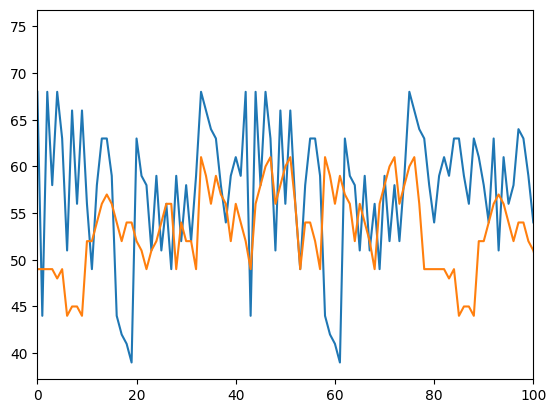

In [53]:
plt.plot(composers['Anglebert']['Serie_39'])

plt.plot(composers['Dowland']['Serie_7'])
plt.xlim(0,100)

In [36]:
def midi_to_hz(midi_notes):
    """
    Convierte una secuencia de notas en formato MIDI a frecuencias en Hz.
    
    Args:
    midi_notes (np.array): Un array de notas MIDI.
    
    Returns:
    np.array: Un array de frecuencias correspondientes en Hz.
    """
    # Fórmula para convertir número MIDI a Hz
    freqs = 440.0 * 2 ** ((midi_notes - 69) / 12.0)
    return freqs


In [37]:
import copy
# composers_interp = copy.deepcopy(composers)
composers_Hz = copy.deepcopy(composers)

for composer in composers_Hz.keys():
    for pieza in composers_Hz[composer].keys():
        subject = composers[composer][pieza]
        composers_Hz[composer][pieza] = midi_to_hz(subject)

In [20]:
# Js = np.full((77,2160), np.nan)
# for x, composer in enumerate(composers_Hz):
#     for y, serie in enumerate(composers_Hz[composer]):
#         f = composers_Hz[composer][serie]
#         Js[x,y] = J_univariante(f, int(len(f)/2), len(f))
#     print(composer)
# np.save('J_composers_Hz.npy', Js)
"""Se calculó la J para cada compositor de cada serie inalterada en el numpy array Js  como J_composers.npy"""

'Se calculó la J para cada compositor de cada serie inalterada en el numpy array Js  como J_composers.npy'

In [25]:
# Ns = np.full((77,2160), np.nan)
# for x, composer in enumerate(composers):
#     for y, serie in enumerate(composers[composer]):
#         Ns[x,y] = len(composers[composer][serie])
# np.save('Ns.npy', Ns)

"""Se guardó la el tamaño de cada serie en Ns.npy"""

In [3]:
np.save('Jotas2.npy', Jotas)

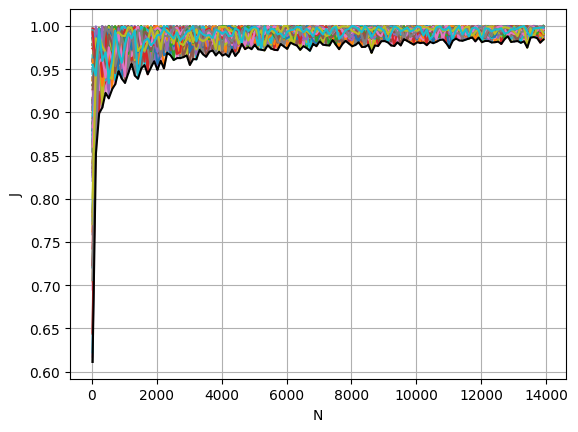

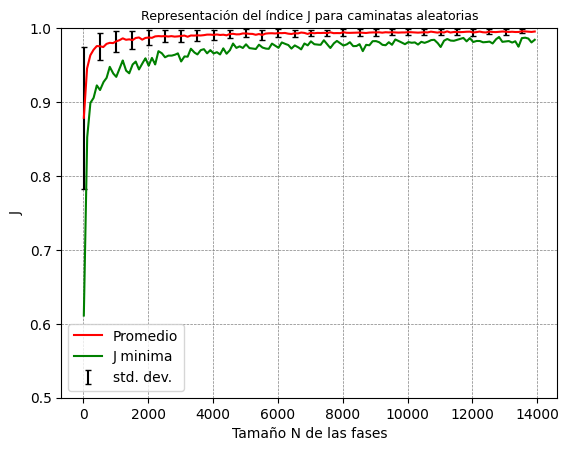

In [55]:
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import pickle

Ns = np.load('Ns.npy')
Js = np.load('J_composers.npy')
Jotas = np.load('Jotas2.npy') #Jotas.npy contiene los 100 vectores de J hipotesis nula
# Jotas = np.zeros((100,len(range(20,14000,100))))
# print(np.shape(Jotas), len(range(20,14000,100)))
# randoms = np.random.uniform(0, 1, (100, 14000))

# for n,i in enumerate(range(20, 14000, 100)):
#     J_univariante_parcial = partial(J_univariante,tau=1,corte=False, i = i)
#     J_por_i = np.apply_along_axis(J_univariante_parcial, axis =1 , arr=randoms[:,:i])
#     Jotas[:,n] = J_por_i
#     print(i)
# print(J_univariante(np.random.uniform(0.0,1.0, 5000), 1, False))
x = np.arange(20, 14000, 100)
xx = np.arange(20, 13921, 1)
J_mean = np.mean(Jotas, axis=0)
J_std = np.std(Jotas, axis = 0)
J_minus = np.min(Jotas, axis=0)

J_minus = interpolador(J_minus, 'lineal', 99)
J_minus_intr = np.zeros((2, 13901))
J_minus_intr[1,:] = J_minus[1]
J_minus_intr[0,:] = xx

np.save('J_minus_continuo.npy', J_minus_intr)
for i in range(100):
    plt.plot(x, Jotas[i,:])
plt.plot(xx, J_minus[1], 'black')
plt.xlabel('N')
plt.ylabel('J')
plt.grid()
plt.show()
fig, ax = plt.subplots()
ax.errorbar(x = x[::5], y = J_mean[::5], yerr= J_std[::5], fmt='none', ecolor = 'black', capsize=2,label='std. dev.')
ax.plot(x, J_mean, color = 'red', label = 'Promedio')

ax.set_ylim(0.5, 1)
ax.set_xlabel('Tamaño N de las fases')
ax.set_ylabel('J') 
# plt.scatter(len(canon), canon_j, marker ='.', color = 'green')
ax.plot(xx, J_minus[1], 'green', label='J minima')
ax.legend()
plt.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
ax.set_title('Representación del índice J para caminatas aleatorias', fontsize=9)
# plt.plot(Ns[0,:], Js[0,:], '.',color = 'blue')
with open('j_null.pkl', 'wb') as f:
    pickle.dump(fig, f)
plt.show()

100
13901


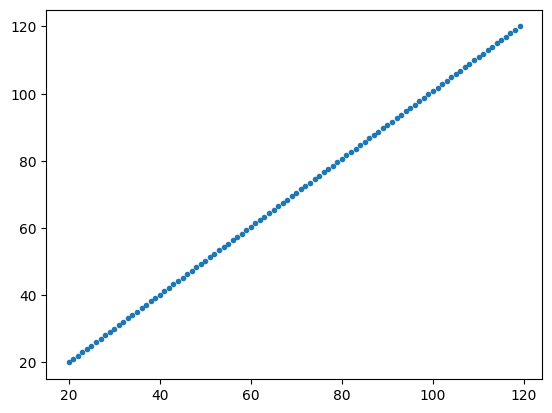

In [46]:
kk = [20, 120]
kk_intrp = interpolador(kk, 'lineal', 98)[1]
print(len(kk_intrp))
plt.plot(range(20,120,1), kk_intrp, '.')
print(len(np.arange(20,13921, 1)))

In [153]:
"""Aquí se graficó J v N para compositor"""
# import matplotlib.pyplot as plt
# import numpy as np

# Ns = np.load('Ns.npy')
# Js = np.load('J_composers.npy')
# Jotas = np.load('Jotas.npy')

# x = range(20, 2000, 10)
# J_mean = np.mean(Jotas, axis=0)
# J_std = np.std(Jotas, axis = 0)

# J_minus = np.min(Jotas, axis=0)

# print('A graficar')
# # Create a figure and subplots
# fig, axs = plt.subplots(40, 2, figsize=(13, 210))

# # Adjust spacing between subplots
# fig.subplots_adjust(hspace=0.4, wspace=0.2)

# # Flatten the axs array to iterate over the subplots
# axs = axs.flatten()

# # Plot data on each subplot
# for i,composer in enumerate(composers):
#         #Siempre
#     axs[i].errorbar(x = x[::5], y = J_mean[::5], yerr= J_std[::5], fmt='none', ecolor = 'black', capsize=2)
#     axs[i].plot(x, J_mean, color = 'red')
#     axs[i].set_ylim(0.5, 1)
#     axs[i].set_xlim(0, 2000)
#     axs[i].set_xlabel('N')
#     axs[i].set_ylabel('J') 
#     axs[i].plot(x, J_minus, 'green')
#     axs[i].grid()
#     #for in
#     axs[i].set_title(composer)
#     axs[i].plot(Ns[i,:], Js[i,:], '.',color = 'blue')

# # Hide any empty subplots
# for j in range(76, 80):
#     axs[j].axis('off')

# plt.suptitle('Distribución del índice j de cada compositor (Datos originales)',
#              fontsize=10)
# plt.subplots_adjust(top=0.9778) 
# plt.show()


'Aquí se graficó J v N para compositor'

In [157]:
"""Boxplots de los J de datos inalterados"""
# import numpy as np
# import matplotlib.pyplot as plt


# Js = np.load('J_composers.npy')
# Ns = np.load('Ns.npy')
# data = [Js[i,:datos_composers[composer]['# Piezas']] for i, composer in enumerate(datos_composers.keys())]


# fig, ax = plt.subplots(figsize=(20, 10))
# ax.boxplot(data, patch_artist=True)


# ax.set_xlabel('Compositor')
# ax.set_ylabel('J index')
# ax.set_xticks(np.arange(1, 78))  
# ax.set_xticklabels([f'{composer}' for i, composer in enumerate(datos_composers.keys())], rotation=90)  # Rotar las etiquetas del eje x

# ax.xaxis.set_label_position('top')  # Movemos la etiqueta del eje x
# ax.xaxis.tick_top()  # Movemos los ticks del eje x a la parte superior
# ax.spines['top'].set_position(('axes', 1.0))  # Movemos la espina superior al tope de la figura
# ax.spines['bottom'].set_position(('axes', -0.1))  # Ocultamos la espina inferior

# plt.setp(ax.get_xticklabels(), rotation=90, ha='center')


# plt.tight_layout()


# plt.show()

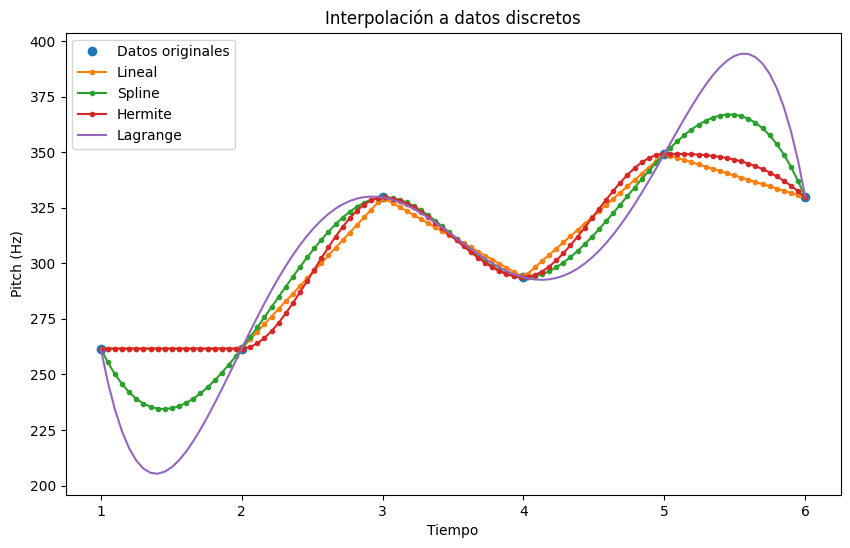

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline
from numpy.polynomial import Polynomial
from scipy.interpolate import lagrange
from scipy.interpolate import PchipInterpolator
from pykrige.ok import OrdinaryKriging


times = np.array([1, 2, 3, 4, 5, 6])
pitches = np.array([261.63, 261.63, 329.63, 293.66, 349.23, 329.63]) 

# Interpolacion Lineal
linear_interp = interp1d(times, pitches, kind='linear')

# Interpolacion Spline
spline_interp = CubicSpline(times, pitches)

# Interpolacion de Lagrange
lagrange_interp = lagrange(times, pitches)

#Interpolacion de Hermite
hermite_interp = PchipInterpolator(times, pitches)


# Generar puntos para graficar
fine_times = np.linspace(1, 6, 100)
linear_pitches = linear_interp(fine_times)
spline_pitches = spline_interp(fine_times)
lagrange_pitches = lagrange_interp(fine_times)
hermite_pitches = hermite_interp(fine_times)


# Graficar
plt.figure(figsize=(10, 6))
plt.plot(times, pitches, 'o', label='Datos originales')
plt.plot(fine_times, linear_pitches, '.-', label='Lineal')
plt.plot(fine_times, spline_pitches, '.-', label='Spline')
plt.plot(fine_times, hermite_pitches, '.-', label='Hermite')
plt.plot(fine_times, lagrange_pitches, label='Lagrange')
plt.xlabel('Tiempo')
plt.ylabel('Pitch (Hz)')
plt.legend()
plt.title('Interpolación a datos discretos')
plt.show()


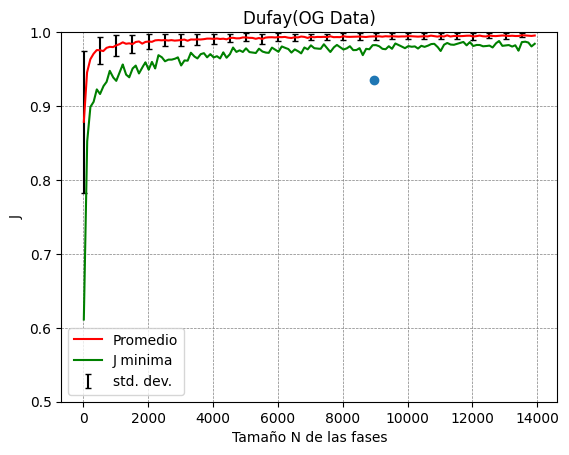

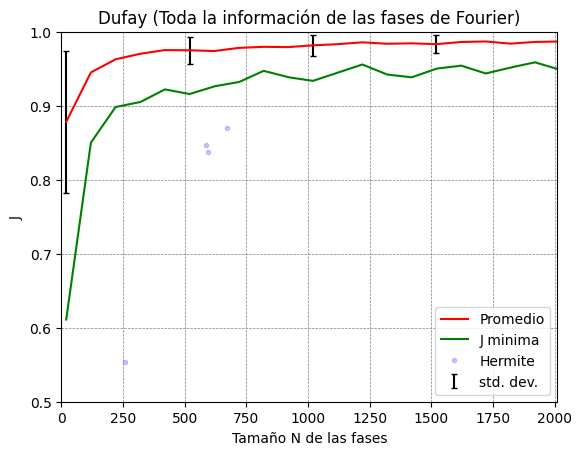

In [ ]:
"""Compute individual"""
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

J_composers = np.load('J_composers_Hz.npy')
Ns = np.load('Ns.npy')
composer = 'Dufay' 
J_lineal_array = []
J_herm_array = []

J_herm_array = np.load('J_interpolacion_hermite/'+str(datos_composers[composer]['Birth_year'])+'_J_interp_'+ composer + '_herm.npy')

with open('j_null.pkl', 'rb') as f:
    fig = pickle.load(f)
num = datos_composers[composer]['Indice']
N = datos_composers[composer]['# Piezas']
plt.scatter(x=8956, y=0.935)
# plt.plot(Ns[num,:], J_composers[num,:], '.', color = 'black',  alpha = 1)
# plt.plot(Ns[num,:N], [1 - x for x in umbral[0]], '.', color = 'red',  alpha = 1)
plt.title(composer + '(OG Data)')
# plt.xlim(0, 2010)
plt.show()


with open('j_null.pkl', 'rb') as f:
    fig = pickle.load(f)
# plt.plot( Ns[num,:N] , J_lineal_array, '.', color = 'red', alpha = 0.2, label = 'Lineal')
plt.plot( Ns[num,:N] , J_herm_array, '.', color = 'blue', alpha = 0.2, label = 'Hermite')
plt.title(composer + ' (Toda la información de las fases de Fourier)')
plt.legend()
plt.xlim(0, 2010)
plt.show()

In [216]:
"""Compute everything"""

import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

J_composers = np.load('J_composers.npy')
Ns = np.load('Ns.npy')

#################
for composer in composers:

    J_interp_lineal = []
    J_interp_hermite = []

    for subject in composers[composer].values():

        interp_lineal = interpolador(subject, 'lineal', 10000)

        interp_herm = interpolador(subject, 'herm', 10000)

        J_lineal = J_univariante(interp_lineal, len(interp_lineal)//2, True)
        J_herm = J_univariante(interp_herm, len(interp_herm)//2, True)

        J_interp_lineal.append(J_lineal)
        J_interp_hermite.append(J_herm)

    np.save('J_interpolacion_lineal_cortado/J_interp_' + str(composer) + '_lineal.npy', np.array(J_interp_lineal))
    np.save('J_interpolacion_hermite_cortado/J_interp_' + str(composer) + '_herm.npy', np.array(J_interp_hermite))

C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_9408\4076517723.py:52: RuntimeWarning: invalid value encountered in scalar divide
  e1=np.sum(e)/len(angulos)


In [12]:
print(datos_composers['Palestrina']['# Piezas'])

61


In [19]:
"""Plot everything"""

# import matplotlib.pyplot as plt
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import PchipInterpolator

# Ns = np.load('Ns.npy')//2
# Jotas = np.load('Jotas.npy')

# x = range(20, 2000, 10)
# J_mean = np.mean(Jotas, axis=0)
# J_std = np.std(Jotas, axis = 0)

# J_minus = np.min(Jotas, axis=0)


# # Create a figure and subplots
# fig, axs = plt.subplots(40, 2, figsize=(13, 210))
# # Adjust spacing between subplots
# fig.subplots_adjust(hspace=0.4, wspace=0.2)

# # Flatten the axs array to iterate over the subplots
# axs = axs.flatten()

# # Plot data on each subplot
# for i,composer in enumerate(composers):
#     #siempre
#     axs[i].errorbar(x = x[::5], y = J_mean[::5], yerr= J_std[::5], fmt='none', ecolor = 'black', capsize=2)
#     axs[i].plot(x, J_mean, color = 'red')
#     axs[i].set_xlim(0, 2010)
#     axs[i].set_xlabel('N/2')
#     axs[i].set_ylabel('J') 
#     axs[i].plot(x, J_minus, 'green')
#     axs[i].grid()
#     #for in
#     J_interp_lineal = np.load('J_interpolacion_lineal_cortado/'+ str(datos_composers[composer]['Birth_year'])+'_J_interp_' + str(composer) + '_lineal.npy')
#     J_interp_hermite = np.load('J_interpolacion_hermite_cortado/'+ str(datos_composers[composer]['Birth_year'])+'_J_interp_' + str(composer) + '_herm.npy')
#     axs[i].set_title(composer)
#     # axs[i].plot(Ns[i,:], Js[i,:], '.',color = 'blue')
#     if len(J_interp_lineal) <= 200:
#         alpha = 0.5
#     elif len(J_interp_lineal) > 200 and len(J_interp_lineal) <= 800:
#         alpha = 0.3
#     else:
#         alpha = 0.2 
#     # axs[i].plot( Ns[i,:datos_composers[composer]['# Piezas'] ], J_interp_lineal, '.', color = 'red', alpha = alpha, label='lineal')
#     axs[i].plot( Ns[i,:datos_composers[composer]['# Piezas']], J_interp_hermite, '.', color = 'blue', alpha = alpha, label='Hermite')
#     axs[i].set_xlim(0, 2010)
#     axs[i].legend()

# # Hide any empty subplots
# for j in range(77, 80):
#     axs[j].axis('off')

# plt.suptitle('Distribución del índice j de cada compositor (Datos interpolados con corte en las fases)',
#              fontsize=10)
# plt.subplots_adjust(top=0.9778) 

# plt.show()

'Plot everything'

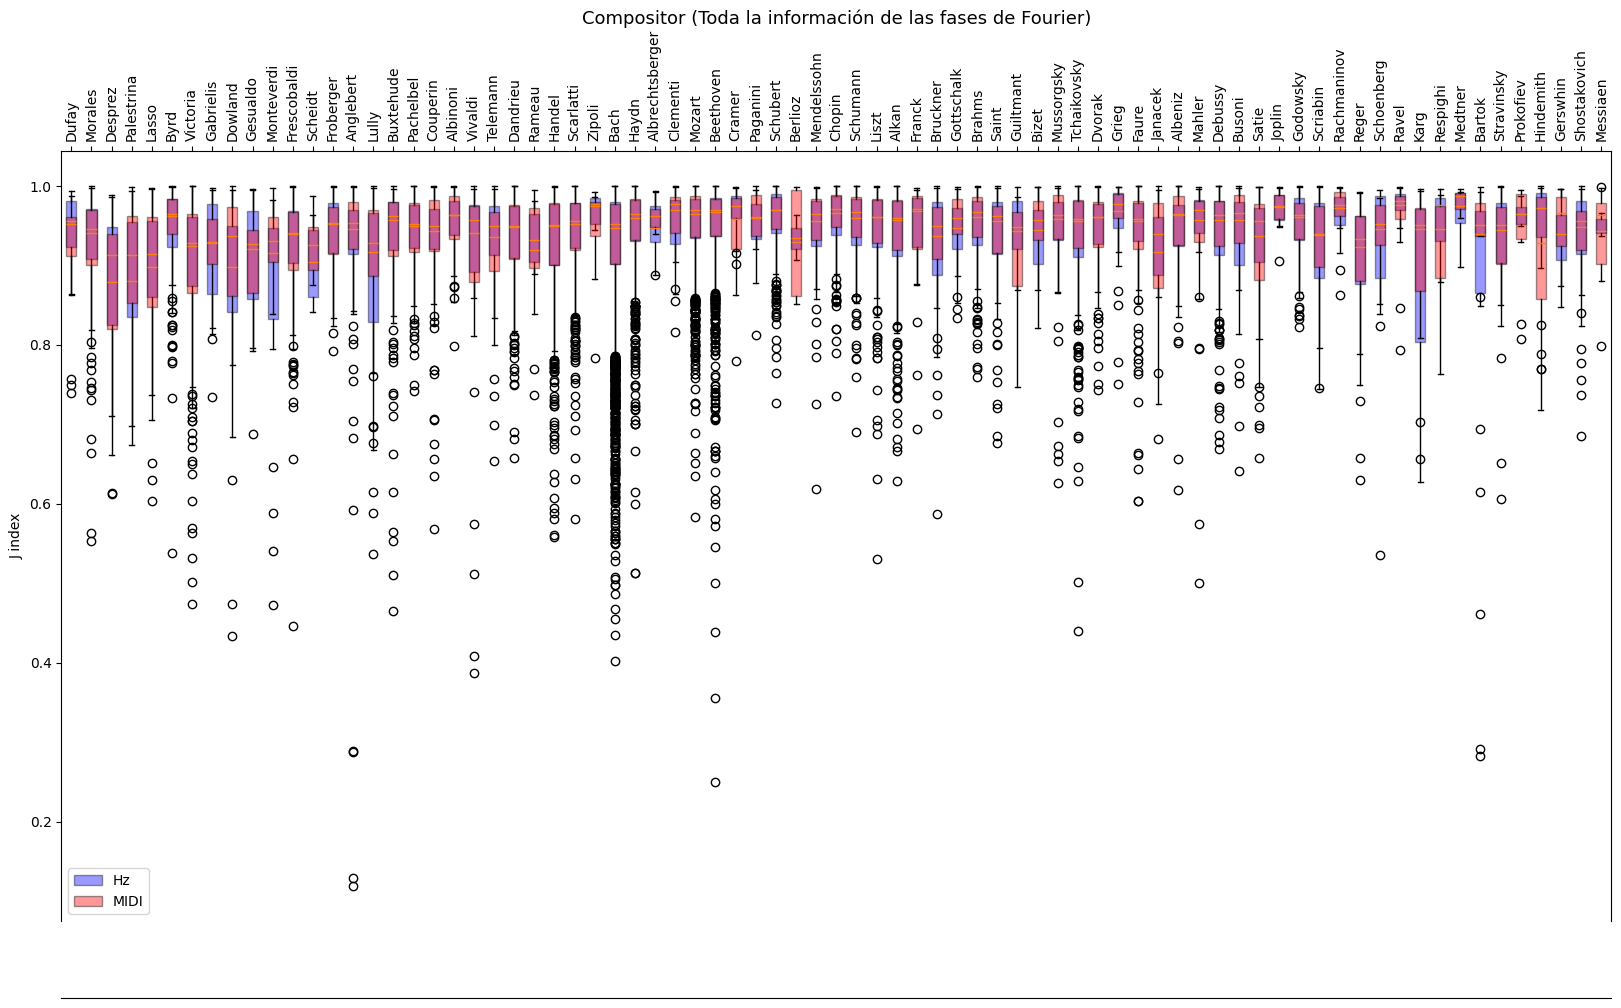

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os

Ns = np.load('Ns.npy')
J_minus_2000 = np.load('J_minus_2000.npy')


carpeta2 = 'J_interpolacion_hermite' 
archivos_en_carpeta2 = os.listdir(carpeta2)

# data2 = [np.load(os.path.join(carpeta2, array)) for array in archivos_en_carpeta2]
data1 = [np.load('J_composers.npy')[array,:] for array in range(77)]
data2 = [np.load('J_composers_Hz.npy')[array,:] for array in range(77)]
Ns_data = [np.load('Ns.npy')[array] for array in range(np.shape(Ns)[0])]

data1 = [array[~np.isnan(array)] for array in data1]
data2 = [array[~np.isnan(array)] for array in data2]
Ns_data = [array[~np.isnan(array)] for array in Ns_data]

for j in range(77):
    for i in range(len(Ns_data[j])):
        if Ns_data[j][i] >= 2000:
            Ns_data[j][i] = 1999

# umbral = [[J_minus_2000[int(i) - 20] for i in Ns_data[j]] for j in range(77)]

fig, ax = plt.subplots(figsize=(20, 10))
box2 = ax.boxplot(data2, patch_artist=True)
box1 = ax.boxplot(data1, patch_artist=True)

for patch in box2['boxes']:
    patch.set_facecolor('blue')
    if patch == box2['boxes'][0]:
        patch.set_label('Hz')
    patch.set_alpha(0.4) 

for patch in box1['boxes']:
    patch.set_facecolor('red')
    if patch == box1['boxes'][0]:
        patch.set_label('MIDI')
    patch.set_alpha(0.4) 

ax.set_xlabel(f'Compositor (Hz vs MIDI)', fontsize=13)
ax.set_ylabel('J index')
ax.set_xticks(np.arange(1, 78))  
ax.legend()
ax.set_xticklabels([f'{composer}' for i, composer in enumerate(datos_composers.keys())], rotation=90)  # Rotar las etiquetas del eje x

ax.xaxis.set_label_position('top')  # Movemos la etiqueta del eje x
ax.xaxis.tick_top()  # Movemos los ticks del eje x a la parte superior
ax.spines['top'].set_position(('axes', 1.0))  # Movemos la espina superior al tope de la figura
ax.spines['bottom'].set_position(('axes', -0.1))  # Ocultamos la espina inferior

plt.setp(ax.get_xticklabels(), rotation=90, ha='center')


# plt.tight_layout()
plt.show()



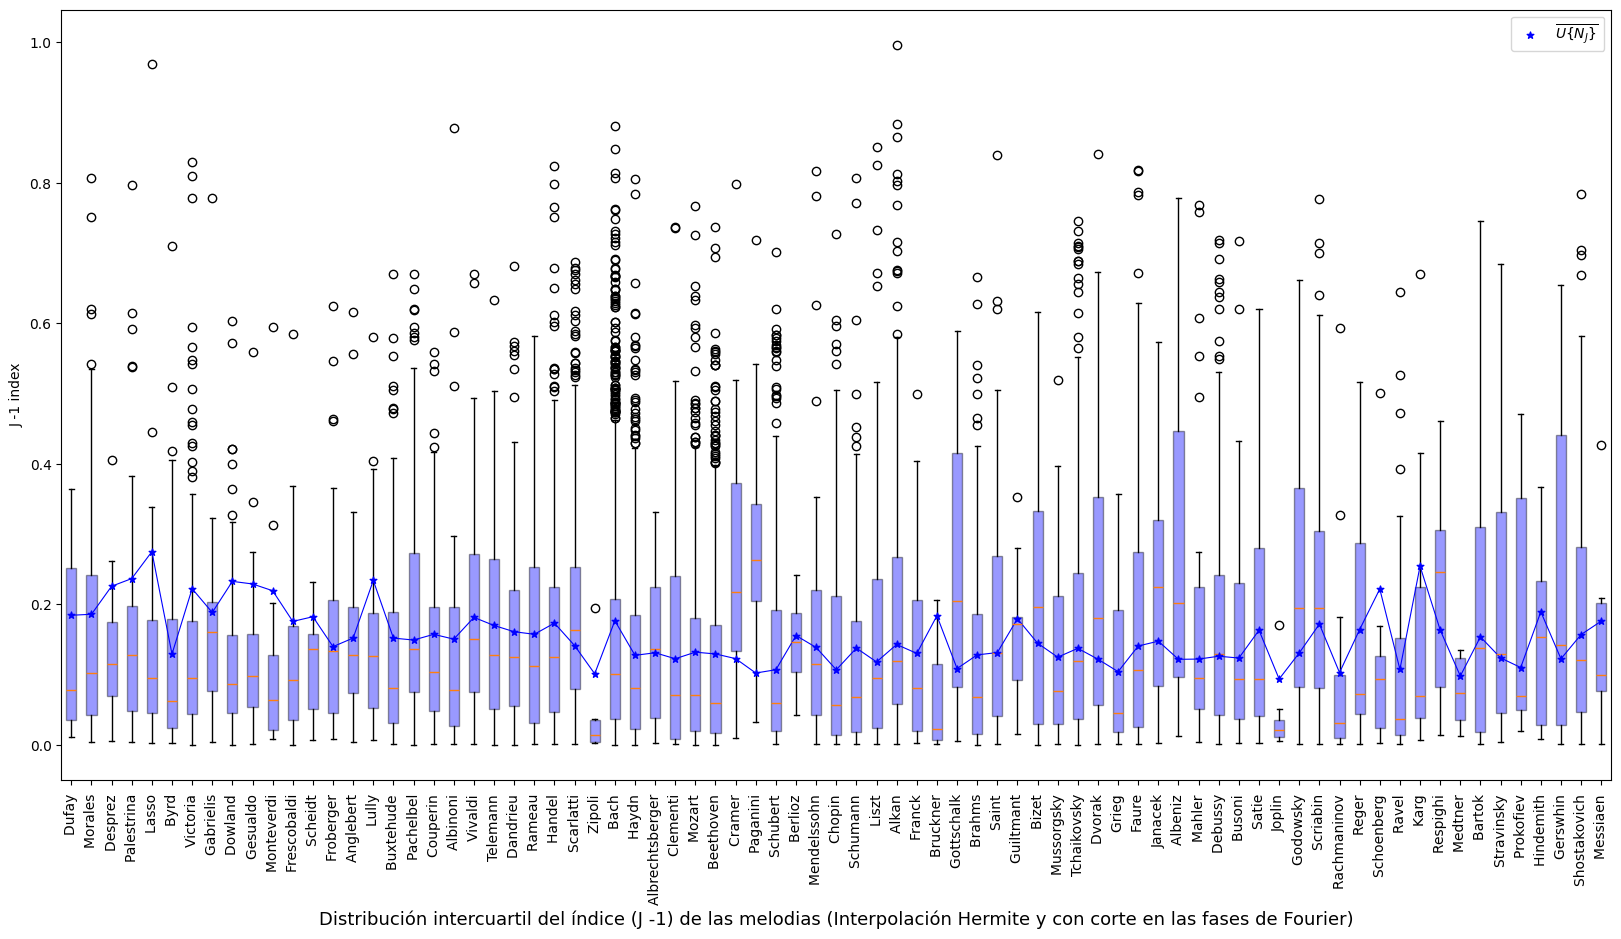

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os

Ns = np.load('Ns.npy')//2
J_minus_2000 = np.load('J_minus_2000.npy')

carpeta1 = 'J_interpolacion_lineal_cortado' 
carpeta2 = 'J_interpolacion_hermite_cortado' 
archivos_en_carpeta1 = os.listdir(carpeta1)
archivos_en_carpeta2 = os.listdir(carpeta2)

data1 = [1 - np.load(os.path.join(carpeta1, array)) for array in archivos_en_carpeta1]
data2 = [1 - np.load(os.path.join(carpeta2, array)) for array in archivos_en_carpeta2]
Ns_data = [Ns[array] for array in range(np.shape(Ns)[0])]
J_OG = [1 - np.load('J_composers.npy')[array] for array in range(np.shape(Ns)[0])]

data1 = [array[~np.isnan(array)] for array in data1]
data2 = [array[~np.isnan(array)] for array in data2]
Ns_data = [array[~np.isnan(array)] for array in Ns_data]
J_OG = [array[~np.isnan(array)] for array in J_OG]


for j in range(77):
    for i in range(len(Ns_data[j])):
        if Ns_data[j][i] >= 2000:
            Ns_data[j][i] = 1999

umbral = [[J_minus_2000[int(i) - 20] for i in Ns_data[j]] for j in range(77)]

# Aquí, asume que `puntos` es la lista con los 77 elementos
puntos1 = [J_minus_2000[int(np.mean(Ns_data[j])) - 20] for j in range(77)]
puntos2 = [np.mean(np.array([1 - J_minus_2000[int(i) - 20] for i in Ns_data[j]])) for j in range(77)]

fig, ax = plt.subplots(figsize=(20, 10))
# box2 = ax.boxplot(J_OG, patch_artist=True)
box2 = ax.boxplot(data2, patch_artist=True)

# Personalización de los boxplots
for patch in box2['boxes']:
    patch.set_facecolor('blue')
#     if patch == box2['boxes'][0]:
#         patch.set_label('Hermite')
    patch.set_alpha(0.4)

ax.set_xlabel(f'Distribución intercuartil del índice (J -1) de las melodias (Interpolación Hermite y con corte en las fases de Fourier)', fontsize=13)
ax.set_ylabel('J -1 index')
ax.set_xticks(np.arange(1, 78))

# ax.scatter(np.arange(1, 78), puntos1, color='red', s=50, zorder=3, marker = '*', label=r'$U\{\overline{N_J}\}$')
ax.scatter(np.arange(1, 78), puntos2, color='blue', s=25, zorder=3, marker = '*', label=r'$\overline{U\{ N_J \}}$')
ax.plot(np.arange(1, 78), puntos2, color='blue', linestyle='-', linewidth=0.8)

ax.legend()
ax.set_xticklabels([f"{composer} " for i, composer in enumerate(datos_composers.keys())], rotation=90)

# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()
# ax.spines['top'].set_position(('axes', 1.0))
# ax.spines['bottom'].set_position(('axes', -0.1))

# plt.setp(ax.get_xticklabels(), rotation=90, ha='center')


plt.show()

In [33]:
print(len(umbral[0]), datos_composers['Dufay']["# Piezas"])

13 13


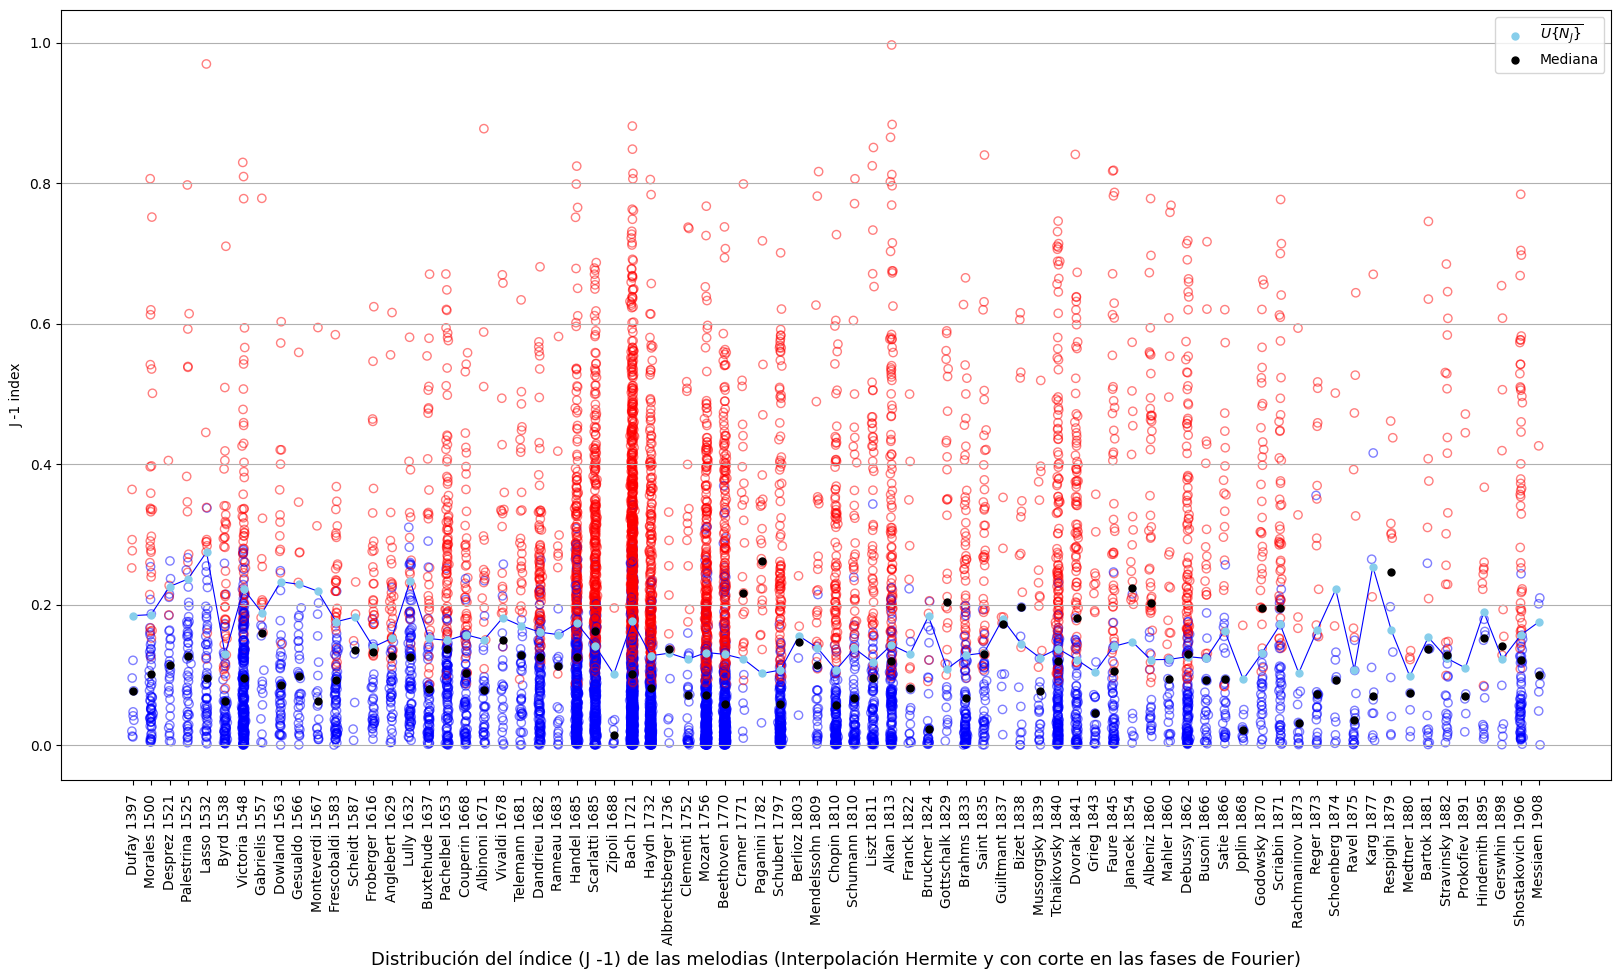

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os

Ns = np.load('Ns.npy')//2
J_minus_2000 = np.load('J_minus_2000.npy')

carpeta1 = 'J_interpolacion_lineal_cortado' 
carpeta2 = 'J_interpolacion_hermite_cortado' 
archivos_en_carpeta1 = os.listdir(carpeta1)
archivos_en_carpeta2 = os.listdir(carpeta2)

data1 = [1 - np.load(os.path.join(carpeta1, array)) for array in archivos_en_carpeta1]
data2 = [1 - np.load(os.path.join(carpeta2, array)) for array in archivos_en_carpeta2]
Ns_data = [Ns[array] for array in range(np.shape(Ns)[0])]
J_OG = [1 - np.load('J_composers.npy')[array] for array in range(np.shape(Ns)[0])]

data1 = [array[~np.isnan(array)] for array in data1]
data2 = [array[~np.isnan(array)] for array in data2]
Ns_data = [array[~np.isnan(array)] for array in Ns_data]
J_OG = [array[~np.isnan(array)] for array in J_OG]


for j in range(77):
    for i in range(len(Ns_data[j])):
        if Ns_data[j][i] >= 2000:
            Ns_data[j][i] = 1999

umbral = [[J_minus_2000[int(i) - 20] for i in Ns_data[j]] for j in range(77)]

# Aquí, asume que `puntos` es la lista con los 77 elementos
puntos1 = [J_minus_2000[int(np.mean(Ns_data[j])) - 20] for j in range(77)]
puntos2 = [np.mean(np.array([1 - J_minus_2000[int(i) - 20] for i in Ns_data[j]])) for j in range(77)]
mediana = [np.median(array) for array in data2]

fig, ax = plt.subplots(figsize=(20, 10))
# box2 = ax.boxplot(data2, patch_artist=True)

for i, (d, u) in enumerate(zip(data2, umbral)):
    # Añadir dispersión para evitar superposición
    x = np.random.normal(i + 1, 0.04, size=len(d))
    colors = ['blue' if d_val < u_val else 'red' for d_val, u_val in zip(d, [1-x for x in u])]
    plt.scatter(x, d, alpha=0.5, color='none', edgecolors=colors)

ax.set_xlabel(f'Distribución del índice (J -1) de las melodias (Interpolación Hermite y con corte en las fases de Fourier)', fontsize=13)
ax.set_ylabel('J -1 index')
ax.set_xticks(np.arange(1, 78))

# ax.scatter(np.arange(1, 78), puntos1, color='red', s=50, zorder=3, marker = '*', label=r'$U\{\overline{N_J}\}$')
ax.scatter(np.arange(1, 78), puntos2, color='#87CEEB', s=25, zorder=3, marker = 'o', label=r'$\overline{U\{ N_J \}}$')
ax.scatter(np.arange(1, 78), mediana, color='black',s=25,zorder=3,marker='o',label='Mediana')
ax.plot(np.arange(1, 78), puntos2, color='blue', linestyle='-', linewidth=0.8)
# ax.plot(np.arange(1, 78), mediana, color='red', linestyle='-', linewidth=0.8)

ax.legend()
ax.set_xticklabels([f"{composer} {datos_composers[composer]['Birth_year']} " for i, composer in enumerate(datos_composers.keys())], rotation=90)


plt.grid(axis='y')
plt.show()

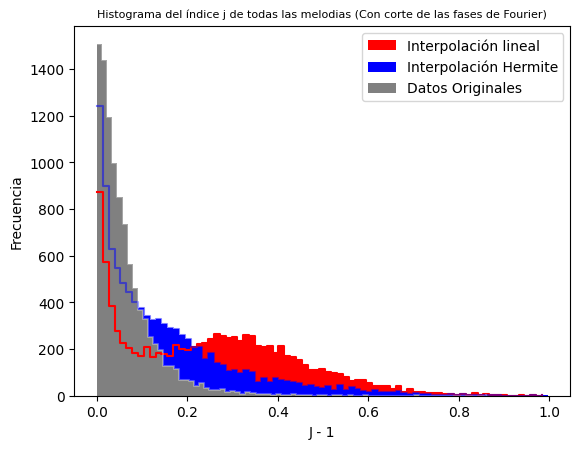

In [41]:
import matplotlib.pyplot as plt
import numpy as np

data1_flat = np.concatenate(data1)
data2_flat = np.concatenate(data2)
OG_data_flat = np.concatenate(J_OG)

# Crear histogramas y obtener los valores de las barras
counts1, bins1, _ = plt.hist(data1_flat, bins=77, color='red', alpha=1, edgecolor='none', label='Interpolación lineal')
counts2, bins2, _ = plt.hist(data2_flat, bins=77, color='blue', alpha=1, edgecolor='none', label='Interpolación Hermite')
counts3, bins3, _ = plt.hist(OG_data_flat, bins=77, color='gray',alpha=1, edgecolor='none', label='Datos Originales')

# Dibujar los contornos superiores de cada histograma
plt.plot(bins1[:-1], counts1, drawstyle='steps-post', color='red')
plt.plot(bins2[:-1], counts2, drawstyle='steps-post', color='blue',alpha = 0.5)
plt.plot(bins3[:-1], counts3, drawstyle='steps-post', color='white',alpha = 0.3)

# Personalizar la gráfica
plt.xlabel('J - 1')
plt.ylabel('Frecuencia')
plt.title('Histograma del índice j de todas las melodias (Con corte de las fases de Fourier)', fontsize=8)
plt.legend()
plt.show()


# DFA

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import fathon
from fathon import fathonUtils as fu

def DFA(time_series):

    # Cargar tus datos en lugar de los generados aleatoriamente
    # Reemplaza esta línea con la carga de tus datos reales
    my_data = np.array(time_series)  # Reemplaza esta línea con tus datos reales

    # Convertir la serie a un formato compatible con Fathon
    my_data = fu.toAggregated(my_data)

    # Determinar la longitud de la serie temporal
    data_length = len(my_data)

    # Ajustar los tamaños de ventana para que no excedan la longitud de los datos
    winSizes = fu.linRangeByStep(10, min(500, data_length // 4))  # Ajusta según la longitud de tus datos
    revSeg = True  # Configura si deseas usar segmentos invertidos
    polOrd = 2     # Orden del polinomio para eliminar la tendencia, ajusta según tu caso

    # Crear el objeto DFA con tus datos
    pydfa = fathon.DFA(my_data)

    # Calcular las fluctuaciones
    n, F = pydfa.computeFlucVec(winSizes, revSeg=revSeg, polOrd=polOrd)


    # Si deseas realizar ajustes múltiples en diferentes rangos, configura los límites aquí
    limits_list = np.array([[20, min(500, data_length // 4)]], dtype=int)  # Ajusta según sea necesario
    list_H, list_H_intercept = pydfa.multiFitFlucVec(limits_list)

    # Graficar los resultados de los múltiples ajustes
    clrs = ['k', 'b', 'm', 'c', 'y']
    stls = ['-', '--', '.-']

    return n, F


In [142]:
import numpy as np
import os
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

def calculate_increment_series(time_series):
    """Calcula la serie de incrementos."""
    return np.diff(time_series)

def decompose_series(increment_series):
    """Descompone la serie de incrementos en magnitudes y signos, y resta las medias."""
    magnitude_series = np.abs(increment_series)
    sign_series = np.sign(increment_series)
    
    # Restar las medias
    magnitude_series -= np.mean(magnitude_series)
    sign_series -= np.mean(sign_series)
    
    return magnitude_series, sign_series

def integrate_series(series):
    """Integra la serie para asegurar que esté positivamente correlacionada."""
    return np.cumsum(series)


def mdfa(time_series):
    """
    Implementación del MDFA siguiendo los pasos especificados.
    :param time_series: Serie temporal (numpy array).
    :param scale_range: Rango de tamaños de ventana para el análisis de escala.
    :return: Exponentes de escala para la serie de magnitudes y signos.
    """
    # Paso 1: Calcular la serie de incrementos
    increment_series = calculate_increment_series(time_series)
    
    # Paso 2: Descomponer la serie de incrementos en magnitud y signo, restar medias
    magnitude_series, sign_series = decompose_series(increment_series)
    
    # Paso 3: Integrar las series de magnitudes y signos
    integrated_magnitude = integrate_series(magnitude_series)
    integrated_sign = integrate_series(sign_series)
    
    # Paso 4: Aplicar DFA a ambas series integradas
    n_mag, F_mag = DFA(integrated_magnitude)
    # alpha_sign = DFA(integrated_sign)

    
    return n_mag, F_mag


def iaaft(time_series, ns, max_iter=10000, tol=1e-9):
    """
    Genera múltiples series temporales surrogadas usando el algoritmo IAAFT.
    
    :param time_series: Serie temporal original (numpy array).
    :param ns: Número de surrogados a generar.
    :param max_iter: Número máximo de iteraciones permitidas para cada surrogado.
    :param tol: Tolerancia para la convergencia del algoritmo.
    :return: Array con surrogados de forma (ns, N), donde N es el tamaño de time_series.
    """
    N = len(time_series)
    surrogates = np.zeros((ns, N))  # Array para almacenar los surrogados

    # Calcular la transformada de Fourier del tiempo serie
    original_fft = np.fft.fft(time_series)
    original_amplitude = np.abs(original_fft)  # Amplitudes del espectro

    # Ordenar los valores de la serie original
    sorted_original = np.sort(time_series)

    for s in range(ns):
        # Crear una permutación aleatoria de la serie original
        surrogate = np.random.permutation(time_series)
        prev_surrogate = surrogate.copy()

        for i in range(max_iter):
            # Ajustar la fase: realizar la FFT y conservar la fase aleatoria
            surrogate_fft = np.fft.fft(surrogate)
            surrogate_phase = np.angle(surrogate_fft)

            # Crear una nueva serie combinando la magnitud original con la fase actual
            new_fft = original_amplitude * np.exp(1j * surrogate_phase)
            surrogate = np.fft.ifft(new_fft).real

            # Ajustar la amplitud: Reordenar los valores del surrogate para coincidir con los del original
            surrogate = sorted_original[np.argsort(np.argsort(surrogate))]

            # Chequear convergencia
            diff = np.linalg.norm(surrogate - prev_surrogate)
            if diff < tol:
                break

            prev_surrogate = surrogate.copy()

        # Guardar el surrogado en el array
        surrogates[s] = surrogate

    return surrogates

In [143]:
import numpy as np
import matplotlib.pyplot as plt

def ajuste_polinomial(x, y, grado):
    """
    Ajusta un polinomio de grado especificado a los datos y grafica el ajuste.
    
    :param x: Array de valores x de los datos.
    :param y: Array de valores y de los datos.
    :param grado: Grado del polinomio a ajustar.
    :return: Coeficientes del polinomio ajustado.
    """
    # Ajustar el polinomio usando np.polyfit
    coeficientes = np.polyfit(x, y, grado)
    
    # Crear un polinomio a partir de los coeficientes ajustados
    polinomio = np.poly1d(coeficientes)
    
    # Evaluar el polinomio ajustado en los puntos x
    y_ajustado = polinomio(x)
    
    # Retornar los coeficientes del polinomio
    return y_ajustado, coeficientes

def evaluar_derivada(coeficientes, x_valor):
    """
    Calcula la primera derivada de un polinomio y la evalúa en un valor arbitrario.
    
    :param coeficientes: Coeficientes del polinomio (array).
    :param x_valor: Valor en el que se desea evaluar la derivada.
    :return: Valor de la primera derivada del polinomio evaluada en x_valor.
    """
    # Crear el polinomio a partir de los coeficientes
    polinomio = np.poly1d(coeficientes)
    
    # Calcular la primera derivada del polinomio
    derivada = np.polyder(polinomio)
    
    # Evaluar la derivada en el valor especificado
    derivada_evaluada = derivada(x_valor)
    
    return derivada_evaluada

In [147]:
import piecewise_regression

# CARGAR DATOS

def main(time_series, method):
    H = []
    # CALCULAR MDFA Ó DFA
    if method == 'MDFA':
        n, F = mdfa(time_series)
    else:
        n, F = DFA(time_series)


    # GENERAR SURROGADOS
    flucts_surrogates = []
    N = 19
    surrogates = iaaft(time_series, N)
    for i in range(N):
        if method == 'MDFA':
            n_surr, flucts_surr = mdfa(surrogates[i,:])
        else:
            n_surr, flucts_surr = DFA(surrogates[i,:])
        flucts_surrogates.append(np.log10(flucts_surr))
    flucts_surrogates = np.vstack(flucts_surrogates)


    # AJUSTAR REGRESIÓN LINEAL SEGMENTADA
    n_breakpoints = 3
    while True: 
        pw_fit = piecewise_regression.Fit(np.log10(n), np.log10(F), n_breakpoints=n_breakpoints)
        pw_results = pw_fit.get_results()
        pw_estimates = pw_results["estimates"]

        if pw_results['converged']:
            for value in pw_estimates:
                if 'alpha' in value:
                    H.append(pw_estimates[value]['estimate'])

            # # GRAFICAR

            pw_fit.plot_data(color="red", s=1,label='log(F(s))') # logF(s)
            pw_fit.plot_breakpoints() #Breakpoints

            lower_bound = np.min(flucts_surrogates, axis=0) # area sombreada surr
            upper_bound = np.max(flucts_surrogates, axis=0) # area sombreada surr
            plt.fill_between(np.log10(n_surr), lower_bound, upper_bound, color='blue', alpha=0.2, label='Surrogates')
            
            # AJUSTAR POLINOMIO CON GRADO # DE BREAKPOINTS
            y_ajustado, coeficientes = ajuste_polinomial(np.log10(n), np.log10(F), grado=n_breakpoints+1)
            # yˆ(xi)
            derivadas = evaluar_derivada(coeficientes, np.log10(n))

            # mean{yˆs'(xi)sur} & σ {(yˆs(xi))sur}
            derivadas_surr = np.zeros([19,len(np.log10(n_surr))])
            for surr_index in range(N):
                y_ajustado_surr, coeficientes_surr = ajuste_polinomial(np.log10(n_surr), flucts_surrogates[surr_index], grado=n_breakpoints+1)
                derivadas_surr[surr_index,:] = evaluar_derivada(coeficientes_surr, np.log10(n_surr))
            derivadas_surr_mean = np.mean(derivadas_surr, axis=0)
            derivadas_surr_std = np.std(derivadas_surr, axis= 0)

            # GrAFICAR POLINOMIO
            plt.plot(np.log10(n), y_ajustado, color='green', label=f'Ajuste polinomial (grado {n_breakpoints+1})')

            plt.xlabel('log(s)', fontsize=14)
            plt.ylabel('log(F(s))', fontsize=14)
            plt.title('DFA', fontsize=14)
            plt.legend(loc=0, fontsize=7)
            plt.show()
            plt.close()
            break
        elif n_breakpoints != 1:
            n_breakpoints= n_breakpoints-1
        else: 
            break

    # CALCULAR INDICE NO LINEALIDAD
    E = np.sum(np.abs(derivadas - derivadas_surr_mean) / derivadas_surr_std)
    E_index = E/len(derivadas)
    return E_index

602


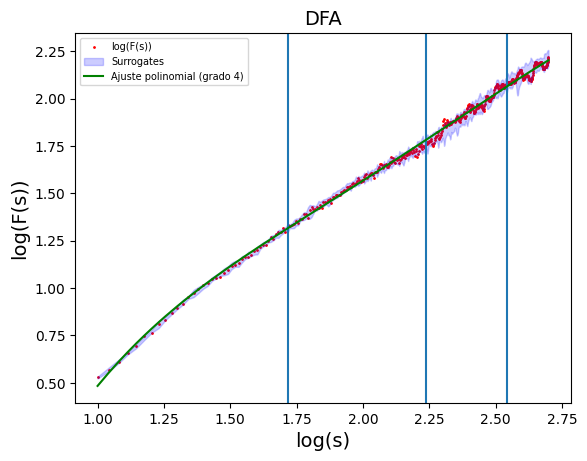

0it [03:38, ?it/s]

0it [00:00, ?it/s]


In [148]:
print(datos_composers['Beethoven']['# Piezas'])
subject = composers['Beethoven']['Serie_1']
if len(subject) > 100:
    E = tqdm(main(subject, 'DFA'))
    print(E)

In [17]:
frontera = True
frontera2 = True
E_list = []
for composer in composers.keys():
    if frontera:
        if composer != 'Schumann':
            continue
        elif composer == 'Schumann':
            print(composer)
            frontera = False         
            for i in range(datos_composers[composer]['# Piezas']): #[serie1, serie2, 3, 507, 508,509,510, 511]
                if frontera2:
                    if i !=2:
                        continue
                    elif i == 2:
                        frontera2 = False
                        print('Serie_',i+1)
                subject = composers[composer]['Serie_'+str(i+1)].to_numpy().astype(float)
                if len(subject) >= 160:
                    E_index = main(subject, 'MDFA')
                    E_list.append(E_index)
            print(composer)
            continue
        
    for i in tqdm(range(datos_composers[composer]['# Piezas']), desc='Composer'): 
        subject = composers[composer]['Serie_'+str(i+1)].to_numpy().astype(float)
        if len(subject) >= 160:
            E_index = main(subject, 'MDFA')
            E_list.append(E_index)
            # print(E_index)

    print(composer)

Beethoven
Serie_ 21
Beethoven
Cramer
Paganini
Schubert
Berlioz
Mendelssohn
Chopin


KeyboardInterrupt: 

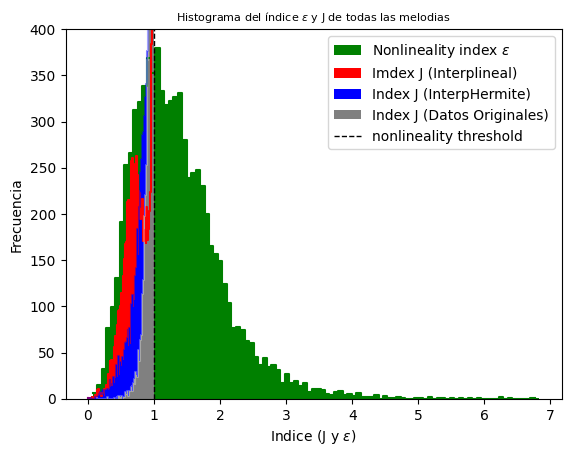

In [81]:
import matplotlib.pyplot as plt
import numpy as np

data_nonlineality = np.load('epsilon_hasta2schumann.npy')
data1_flat = np.concatenate(data1)
data2_flat = np.concatenate(data2)
OG_data_flat = np.concatenate(J_OG)

# Crear histogramas y obtener los valores de las barras
counts_epsilon, bins_epsilon, _ = plt.hist(data_nonlineality,bins=100, color='green', alpha=1, edgecolor='none', label=f'Nonlineality index $\epsilon$')
counts1, bins1, _ = plt.hist(1-data1_flat,bins=77, color='red', alpha=1, edgecolor='none', label='Imdex J (Interplineal)')
counts2, bins2, _ = plt.hist(1-data2_flat, bins=77, color='blue', alpha=1, edgecolor='none', label='Index J (InterpHermite)')
counts3, bins3, _ = plt.hist(1-OG_data_flat, bins=77, color='gray',alpha=1, edgecolor='none', label='Index J (Datos Originales)')

# Dibujar los contornos superiores de cada histograma
plt.plot(bins_epsilon[:-1], counts_epsilon, drawstyle='steps-post', color='green')
plt.plot(bins1[:-1], counts1, drawstyle='steps-post', color='red')
plt.axvline(x=1, color='black', linestyle='--', linewidth=1, label='nonlineality threshold')
plt.plot(bins2[:-1], counts2, drawstyle='steps-post', color='blue',alpha = 0.5)
plt.plot(bins3[:-1], counts3, drawstyle='steps-post', color='white',alpha = 0.3)

# Personalizar la gráfica
plt.xlabel(r'Indice (J y $\epsilon$)')
plt.ylabel('Frecuencia')
plt.ylim(0,400)
plt.title(r'Histograma del índice $\epsilon$ y J de todas las melodias', fontsize=8)
plt.legend()
plt.show()


In [85]:
# spearman_corr, _ = spearmanr(x, y)
# pearson_corr = np.corrcoef(x, y)[0, 1]

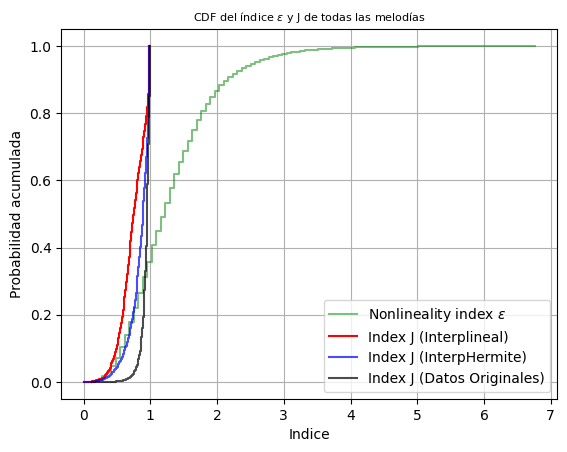

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Cargar los datos
data_nonlineality = np.load('epsilon_hasta2schumann.npy')
data1_flat = np.concatenate(data1)
data2_flat = np.concatenate(data2)
OG_data_flat = np.concatenate(J_OG)

# Calcular los histogramas
counts_epsilon, bins_epsilon = np.histogram(data_nonlineality, bins=100, density=True)
counts1, bins1 = np.histogram(1 - data1_flat, bins=77, density=True)
counts2, bins2 = np.histogram(1 - data2_flat, bins=77, density=True)
counts3, bins3 = np.histogram(1 - OG_data_flat, bins=77, density=True)

# Calcular la CDF a partir de los histogramas
cdf_epsilon = np.cumsum(counts_epsilon) * np.diff(bins_epsilon)
cdf1 = np.cumsum(counts1) * np.diff(bins1)
cdf2 = np.cumsum(counts2) * np.diff(bins2)
cdf3 = np.cumsum(counts3) * np.diff(bins3)

# Graficar las CDFs
plt.plot(bins_epsilon[:-1], cdf_epsilon, drawstyle='steps-post',alpha=0.5, color='green', label=r'Nonlineality index $\epsilon$')
plt.plot(bins1[:-1], cdf1, drawstyle='steps-post', color='red', label='Index J (Interplineal)')
plt.plot(bins2[:-1], cdf2, drawstyle='steps-post', color='blue', alpha=0.7, label='Index J (InterpHermite)')
plt.plot(bins3[:-1], cdf3, drawstyle='steps-post', color='black', alpha=0.7, label='Index J (Datos Originales)')

# Línea vertical en x=1
# plt.axvline(x=1, color='black', linestyle='--', linewidth=2, label='nonlineality threshold')

# Personalizar la gráfica
plt.xlabel(r'Indice')
plt.ylabel('Probabilidad acumulada')
plt.title(r'CDF del índice $\epsilon$ y J de todas las melodías', fontsize=8)
plt.legend()
plt.grid(True)
plt.show()
